In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import nltk

from nlu_engine import NLUEngine
from nlu_engine import MacroDataRefinement
from nlu_engine import MacroIntentRefinement

from nlu_engine import DataUtils
from nlu_engine import RenderJSON

from nlu_engine import Analytics

from nlu_engine import IntentMatcher, LR
from nlu_engine import EntityExtractor

# Macro NLU Data Refinement

It's a bit like the TV show [Serverance](https://www.imdb.com/title/tt11280740/) .

![Helly R and Mark S](https://media.npr.org/assets/img/2022/02/15/atv_severance_photo_010103-5f8033cc2b219ba64fe265ce893eae4c90e83896-s1100-c50.jpg "Helly R and Mark G")

*Helly R*: `My job is to scroll through the spreadsheet and look for the numbers that feel scary?`

*Mark S*: `I told you, you’ll understand when you see it, so just be patient.`

![MDR](https://www.imore.com/sites/imore.com/files/styles/large/public/field/image/2022/03/refinement-software-severance-apple-tv.jpg "serverance micro data refinement")

*Helly R*: `That was scary. The numbers were scary.`

Hopefully the intents and entities that are wrong aren't scary, just a bit frustrating. Let's see if we can find the right ones.

NOTE: We will use Logistic Regression with TFIDF features to train our intent models and CRFs for entity exraction. Why? Well, they are very fast and both methods aren't state-of-the-art. This is good, because it is easier to find problems we will need to refine in the dataset than if we were to use a proper NLU engine like Snips or something SOTA like BERT. It is very important to note that some of the the problems we will pick up on, might not be an actual issue, but might be due to the limitations of the models. Refining the real problems and ignoring the limitations of the models is a good way to improve the models. Then when the dataset is ready, we can use some more advanced NLU engine and get the best performance possible.

* Macro NLU Data Refinement: Intent
* Macro NLU Data Refinement: Entity


Load the dataset

In [2]:
try:
    nlu_data_df = pd.read_csv(
        'data/refined/nlu_data_refined_df.csv', sep=',', index_col=0)
    print('Successfully loaded nlu_data_refined_df.csv')
except:
    data = 'data/NLU-Data-Home-Domain-Annotated-All-Cleaned.csv'
    nlu_data_df = DataUtils.load_data(
    data
)

Successfully loaded nlu_data_refined_df.csv


In [5]:
# TODO: Remove this when done.It's just for testing!
data = 'data/NLU-Data-Home-Domain-Annotated-All-Cleaned.csv'
nlu_data_df = DataUtils.load_data(
    data
)

In [ ]:
removed_nlu_data_refined_df = nlu_data_df[nlu_data_df['remove'] != True]

removed_nlu_data_refined_df

In [6]:
nlu_data_df

,userid,answerid,notes,question,suggested_entities,answer,answer_normalised,scenario,intent,predicted_label,intent_refined,entity_refined,remove,status,answer_annotation
0,1.0,1.0,NaN,Write what you would tell your PDA in the foll...,"date, time",wake me up at 5am this week,wake me up at five am this week,alarm,alarm_set,NaN,NaN,NaN,NaN,NaN,wake me up at [time : five am] [date : this week]
1,1.0,2.0,NaN,Write what you would tell your PDA in the foll...,"date, time",wake me up at 9am on Friday,wake me up at nine am on friday,alarm,alarm_set,NaN,NaN,NaN,NaN,NaN,wake me up at [time : nine am] on [date : friday]
2,1.0,3.0,NaN,Write what you would tell your PDA in the foll...,"date, time",set an alarm for two hours from now,set an alarm for two hours from now,alarm,alarm_set,NaN,NaN,NaN,NaN,NaN,set an alarm for [time : two hours from now]
3,1.0,31.0,NaN,Write what you would tell your PDA in the foll...,player_setting,Olly quiet!,quiet,audio,volume_mute,NaN,NaN,NaN,NaN,NaN,quiet
5,1.0,33.0,NaN,Write what you would tell your PDA in the foll...,player_setting,Olly pause for ten seconds,pause for ten seconds,audio,volume_mute,NaN,NaN,NaN,NaN,NaN,pause for [time : ten seconds]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25711,NaN,781.0,NaN,NaN,NaN,"that's cool, musch appreciated, olly.","that's cool, musch appreciated, olly.",general,praise,NaN,NaN,NaN,NaN,NaN,"that's cool, musch appreciated, olly."
25712,NaN,782.0,NaN,NaN,NaN,"you are hero, appreciated.","you are hero, appreciated.",general,praise,NaN,NaN,NaN,NaN,NaN,"you are hero, appreciated."
25713,NaN,783.0,NaN,NaN,NaN,"thanks, that's nice.","thanks, that's nice.",general,praise,NaN,NaN,NaN,NaN,NaN,"thanks, that's nice."
25714,NaN,784.0,NaN,NaN,NaN,"that's cool, thank you so much.","that's cool, thank you so much.",general,praise,NaN,NaN,NaN,NaN,NaN,"that's cool, thank you so much."


## Intent

### Create intent classifier report

Let's do a report by domain classification.

In [3]:
domain_labels = 'scenario'

domain_report_df = NLUEngine.evaluate_intent_classifier(
    data_df_path=nlu_data_df,
    labels_to_predict=domain_labels,
    classifier=LR
)

domain_report_df

Evaluating LogisticRegression(random_state=0, solver='liblinear')
Cross validating with LogisticRegression(random_state=0, solver='liblinear')
Time it took to cross validate LogisticRegression(random_state=0, solver='liblinear'): 7.119175434112549
Generating report for LogisticRegression(random_state=0, solver='liblinear')


,domain,precision,recall,f1-score,support,classifier,encoding
0,alarm,0.990893,0.899174,0.942808,605.000000,LogisticRegression,tfidf
1,audio,0.950000,0.756219,0.842105,402.000000,LogisticRegression,tfidf
2,calendar,0.841991,0.927768,0.882801,2935.000000,LogisticRegression,tfidf
3,cooking,0.938144,0.675743,0.785612,404.000000,LogisticRegression,tfidf
4,datetime,0.849254,0.816356,0.832480,697.000000,LogisticRegression,tfidf
5,email,0.955677,0.912993,0.933848,1724.000000,LogisticRegression,tfidf
6,general,0.815404,0.832813,0.824017,6089.000000,LogisticRegression,tfidf
7,iot,0.971200,0.936728,0.953653,1296.000000,LogisticRegression,tfidf
8,lists,0.924945,0.881178,0.902531,951.000000,LogisticRegression,tfidf
9,music,0.903226,0.660617,0.763103,551.000000,LogisticRegression,tfidf


It might be easier to see this graphed.

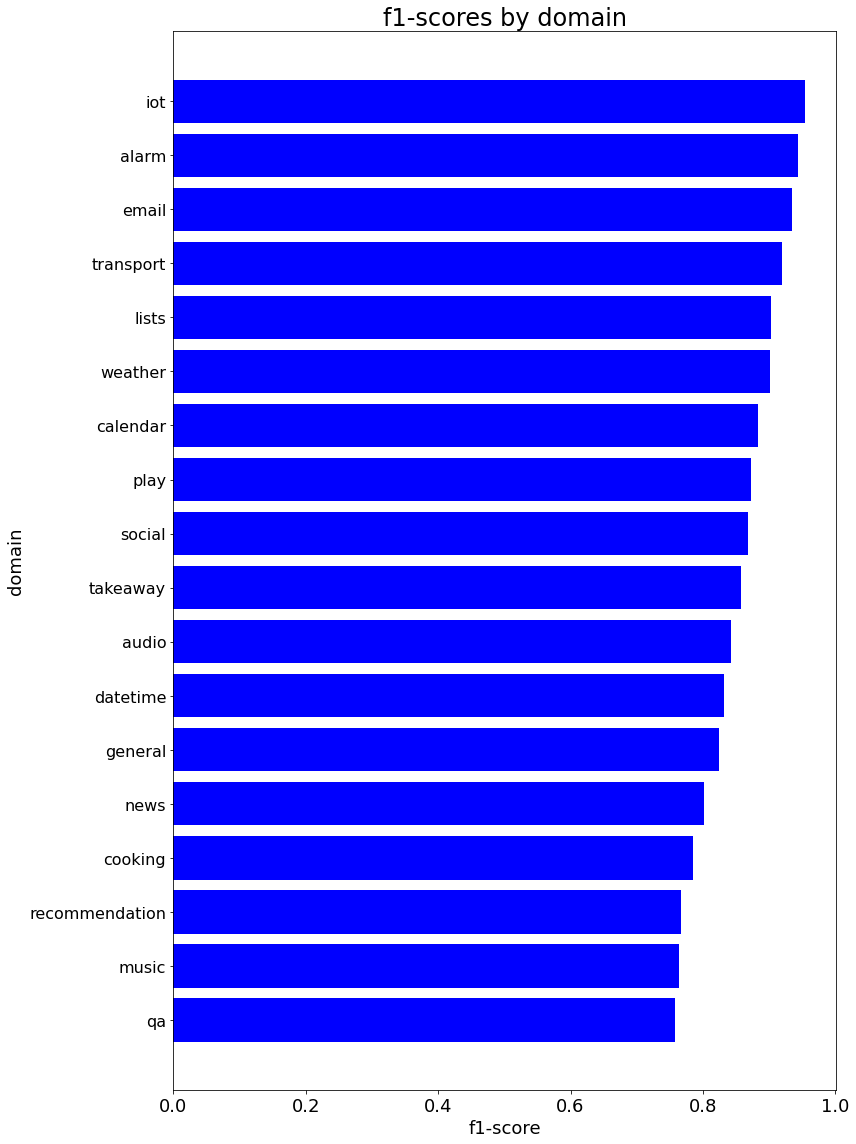

In [4]:
Analytics.plot_report(domain_report_df)

And now let's do a report by intent classification.

In [14]:
intent_labels= 'intent'

intent_report_df = NLUEngine.evaluate_intent_classifier(
    data_df_path=nlu_data_df,
    labels_to_predict=intent_labels,
    classifier=LR
)
intent_report_df

Evaluating LogisticRegression(random_state=0, solver='liblinear')
Cross validating with LogisticRegression(random_state=0, solver='liblinear')
Time it took to cross validate LogisticRegression(random_state=0, solver='liblinear'): 27.37759804725647


/home/bartmoss/code/NLU-engine-prototype-benchmarks/.venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Generating report for LogisticRegression(random_state=0, solver='liblinear')


,intent,precision,recall,f1-score,support,classifier,encoding
0,addcontact,0.909091,0.574713,0.704225,87.000000,LogisticRegression,tfidf
1,affirm,0.988868,0.962094,0.975297,554.000000,LogisticRegression,tfidf
2,alarm_query,0.898089,0.708543,0.792135,199.000000,LogisticRegression,tfidf
3,alarm_remove,0.938462,0.521368,0.670330,117.000000,LogisticRegression,tfidf
4,alarm_set,0.773770,0.816609,0.794613,289.000000,LogisticRegression,tfidf
...,...,...,...,...,...,...,...
66,wemo_off,0.926829,0.775510,0.844444,98.000000,LogisticRegression,tfidf
67,wemo_on,0.981481,0.697368,0.815385,76.000000,LogisticRegression,tfidf
68,accuracy,0.833333,0.833333,0.833333,0.833333,LogisticRegression,tfidf
69,macro avg,0.851374,0.726626,0.768686,25074.000000,LogisticRegression,tfidf


A graph might also be nice here..

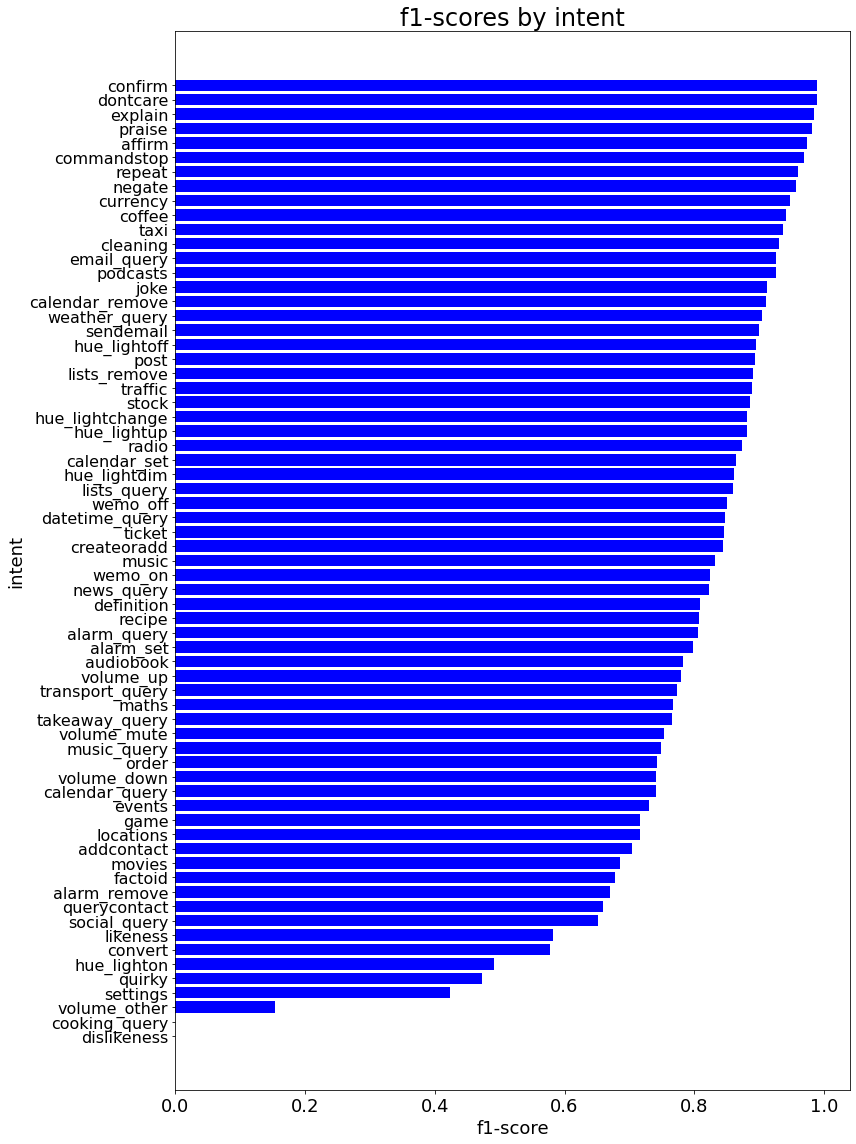

In [7]:
Analytics.plot_report(intent_report_df)

### Macro Intent Data Refinement

<span style="color: red;">For changing to another domain, start here again.</span>

Let's train a classifier with the current state of the data and get the predicted intent labels.

<span style="color: red;">If you have already performed refinements, this will refresh the predicted labels.</span>

(why not split a training test set? Because we want to see the results of the intent classifier on the whole data set, I mean if it's still getting it wrong when it has trained on it, then perhaps there is something wrong with the utterance, tagging, overlapping intents, etc.)

In [10]:
LR_intent_classifier_model, tfidf_vectorizer = NLUEngine.train_intent_classifier(
    data_df_path=nlu_data_df,
    labels_to_predict='intent',
    classifier=LR
)

nlu_data_df = IntentMatcher.get_predicted_labels(
    nlu_data_df, LR_intent_classifier_model, tfidf_vectorizer)

Training LogisticRegression(random_state=0, solver='liblinear')


Now that we know what works and what doesn't, we can start refining the intents.

For each domain, this step will be repeated until all intents have been refined.

Pick a domain (scenario) to review

In [7]:
domain_selection = MacroDataRefinement.list_and_select_domain(nlu_data_df)

We want to get all of the entries for that domain.

In [8]:
domain_df = DataUtils.get_domain_df(nlu_data_df, domain_selection)

Successfully loaded dataframe


We will get the intent keyword features and their rankings (coefs) from the intent classifier.

In [ ]:
#TODO: This will be removed in a later version (no need to rank in the reports, it isn't so helpful!)

In [11]:
intent_feature_rank_df = MacroIntentRefinement.intent_keyword_feature_rankings(
    LR_intent_classifier_model, tfidf_vectorizer)

Having all of the incorrectly predicted intents to review for this domain is a good way to see what is going wrong. Especially when you have used them all as a training set, and yet it still can't predict some entries correctly.

The big question is: Is it because of defects in the data or is it because of the intent classifier? We really want to find defects in the data to refine over classifier defects.

In [12]:
incorrect_intent_predictions_df = IntentMatcher.get_incorrect_predicted_labels(
    domain_df, LR_intent_classifier_model, tfidf_vectorizer)
incorrect_intent_predictions_df

,question,answer_normalised,scenario,intent,predicted_label,answer_annotation
44,Write what you would tell your PDA in the foll...,stop seven am alarm,alarm,alarm_remove,alarm_set,stop [time : seven am] alarm
179,How would you ask your PDA to remove an alarm ...,delete the alarm i just set,alarm,alarm_remove,alarm_set,delete the alarm i just set
210,Write what you would tell your PDA in the foll...,alert me at three pm to goto the concert,alarm,alarm_set,calendar_set,alert me at [time : three pm] to goto the [eve...
212,How would you ask your PDA to tell you about t...,did i set an alarm to wake up in the morning,alarm,alarm_query,alarm_set,did i set an alarm to [alarm_type : wake up] i...
512,How would you ask your PDA to tell you about t...,do i have an alarm set,alarm,alarm_query,alarm_set,do i have an alarm set
...,...,...,...,...,...,...
10258,Write what you would tell your PDA in the foll...,set a repeating reminder alarm for the faceboo...,alarm,alarm_set,calendar_set,set a repeating reminder alarm for the [media_...
10270,Write what you would tell your PDA in the foll...,set an alert for two pm,alarm,alarm_set,calendar_set,set an alert for [time : two pm]
10469,Write what you would tell your PDA in the foll...,schedule an alarm for next weeks dentist appoi...,alarm,alarm_set,calendar_query,schedule an alarm for [date : next weeks] [eve...
10818,Write what you would tell your PDA in the foll...,set alarm for this event reminder repeating fo...,alarm,alarm_set,calendar_set,set alarm for this event reminder [event_name ...


However, it can be a bit much seeing everything that isn't working right, perhaps we can break it down better in a report!

Let's take a look at the report. You can use the circle with the plus to expand the items individually in the report or click on the number of items. Might I recommend looking at one intent at a time and expanding the nested items for each of those. There is a lot of information to look at here, but this stuff is super important to understand for the refinement of the data.

Each intent has the following items:
* **f1 score**: the overall score of the intent(we wanrt to improve this number!)
* **total count**: the total number of utterances that have this intent
* **total incorrect count**: the total number of utterances that have this intent but are incorrectly predicted(we want to reduce this number!)
* **top features**: the top ten features(words) that are associated with this intent(these are just the individual words ranked, not combined together!)
* **overlapping features**: the top ten features(words) that are associated with this intent and are also associated with other intents that may make classification based solely on these features difficult
* **correct utterance example**: the intent, the first annotated utterance that is correctly predicted as an example, and a list of the words in the utterance with their coefficient rankings
* **incorrect utterance example**: the intent, the first annotated utterance that is incorrectly predicted as an example, and a list of the words in the utterance with their coefficient rankings
* **incorrect predicted intents and counts**: for this intent, a list of the incorrectly predicted intents and their counts(we want to reduce this!)


In [15]:
incorrect_predicted_intents_report = MacroIntentRefinement.get_incorrect_predicted_intents_report(
    domain_df, incorrect_intent_predictions_df, intent_report_df, intent_feature_rank_df)

# TODO: Remove unused measures.
RenderJSON(incorrect_predicted_intents_report)

In [ ]:
#TODO: check why it doesn't display

In [16]:
RenderJSON(incorrect_predicted_intents_report)

In [17]:
incorrect_predicted_intents_report

{'alarm_remove': {'f1_score': 0.67,
  'total_count': 117,
  'total_incorrect_count': 36,
  'top_features': ['alarm',
   'remove',
   'alarms',
   'cancel',
   'off',
   'removed',
   'disable',
   'delete',
   'wake',
   'rid'],
  'overlapping_features': [{'intent': 'alarm_query',
    'feature': 'alarms',
    'coef': 10.160949839305223},
   {'intent': 'alarm_set', 'feature': 'alarm', 'coef': 8.873019421348754},
   {'intent': 'hue_lightoff', 'feature': 'off', 'coef': 8.829801974132113},
   {'intent': 'calendar_remove',
    'feature': 'delete',
    'coef': 8.530851319752323},
   {'intent': 'lists_remove', 'feature': 'remove', 'coef': 7.891740024626758},
   {'intent': 'alarm_query', 'feature': 'alarm', 'coef': 7.404020879827028},
   {'intent': 'calendar_remove',
    'feature': 'remove',
    'coef': 7.3099908377546505},
   {'intent': 'lists_remove', 'feature': 'delete', 'coef': 6.952396920134021},
   {'intent': 'wemo_off', 'feature': 'off', 'coef': 6.8714287083733545},
   {'intent': 'comma

It's always a good idea to save the report.

In [ ]:
DataUtils.save_json(incorrect_predicted_intents_report, 'data/reports/' +
                    domain_selection + '_incorrect_predicted_intents_report.json')

In [ ]:
#TODO: add in way to show the improvements when refinement is complete (save original json and new json as one file with two main keys), how best to compare them?

And finally, we will save a dictionary of all of the incorrectly predicted intents for each intent to refine in this domain.

In [18]:
intent_refinement_dictionary = MacroIntentRefinement.get_intent_dataframes_to_refine(
    incorrect_intent_predictions_df)

### Intent refinement: human in the for loop.

<span style="color: red;">For changing to another intent to refine within the same domain, start here again.</span>

Now it's your turn to shine human!

You will provide a refinement to each incorrectly predicted intent. some of the incorrectly predicted utterances are actually fine the way they are, you may need to review the intent that is fasly being predicted...


Besides correcting the utterances(e.g. spelling or grammar), you can also mark an entry with the following:
* **review**: the utterance needs to be reviewed again by a human
* **move**: the utterance needs to be moved to another intent(NOTE: if you have a big data set, it might be better to just **remove** the utterance from the data set)
* **remove**: the utterance should be removed from the dataset

You can use your human ability to refine the NLU intent data by answering the following questions:

0. What should this intent actually do in general? There is usually a specific action the intent should do, and some of the utterances are mislabeled or are not specific enough. If you can't exactly place the utterance without any context (just the untagged utterance by itself), then an AI can't either. 

1. Does the utterance fit to the intent? -> mark as move, remove, and/or review

2. Is the utterance grammar or spelling wrong but(1) is fine? -> correct the utterance

3. Is this intent collidating with another intent because the scope of both intents are overlapping? -> redefine the scope of the intents (either combine them or separate their functionality better)

4. Is the intent collidating with another intent because certain keywords overlap between intents? -> redefine the keywords to split between intents or merge them together if they are similar


From the list of intents, pick one to refine.


In [24]:
intent_to_refine = MacroIntentRefinement.list_and_select_intent(incorrect_intent_predictions_df)

It's good to take a quick second look at entries that are predicted correctly, to see what this intent is supposed to be doing (but perhaps even some of these are wrong too, LOL)

In [25]:
domain_df[(domain_df['intent'] == intent_to_refine) & (
    domain_df['intent'] == domain_df['predicted_label'])].head(10)

,question,answer_normalised,scenario,intent,predicted_label,answer_annotation


<span style="color: red;">In rare occasions, you may want to remove the whole intent from the data set. This can be useful when the whole intent doesn't make sense or is out of scope. Run this and the next cell ONLY if you are sure you want to remove the whole intent, not just the incorrect predictions! Then start on the next domain again further above. </span>

In [ ]:
updated_df = MacroIntentRefinement.remove_intent(nlu_data_df, intent_to_refine)

<span style="color: red;">Save the state of the data set with the removed intent, and then start again on the next intent or domain at the top.</span>

In [ ]:
updated_df.to_csv('data/refined/nlu_data_refined_df.csv')
nlu_data_df = pd.read_csv(
    'data/refined/nlu_data_refined_df.csv', sep=',', index_col=0)

Let's refine the incorrect predictions of this intent!

In [26]:
to_review_sheet = MacroDataRefinement.create_sheet(
    intent_refinement_dictionary[intent_to_refine])
to_review_sheet

Sheet(cells=(Cell(column_end=0, column_start=0, numeric_format=None, row_end=35, row_start=0, squeeze_row=Fals…

Let's save the reviewed data set.

In [ ]:
reviewed_intent_df = MacroDataRefinement.convert_sheet_to_dataframe(
    to_review_sheet)

In [ ]:
reviewed_intent_df.to_csv(
    'data/reviewed/reviewed_'+ domain_selection + '_' + intent_to_refine + '_incorrectly_predicted_df.csv')

In [ ]:
#TODO: Remove this when done.
reviewed_intent_df = pd.read_csv(
    'data/reviewed/reviewed_' + domain_selection + '_' + intent_to_refine + '_incorrectly_predicted_df.csv', sep=',', index_col=0)

For entries that have been marked `move`, we will need to know the intent that they are moving to.

In [ ]:
#TODO: add in list of intents above this cell so people can see if it's the right intent to pick
#TODO: BUG: change method to look up scenario for changed intent to relabel the scenario
refined_intent_df = reviewed_intent_df.apply(
    MacroDataRefinement.move_entry, axis=1)

It's probably a good idea to save this in a csv!

In [ ]:
refined_intent_df.to_csv(
    'data/refined/refined_' + domain_selection + '_' + intent_to_refine + '_incorrectly_predicted_df.csv', sep=',')

In [ ]:
#TODO: Remove this when done.
refined_intent_df = pd.read_csv(
    'data/refined/refined_' + domain_selection + '_' + intent_to_refine + '_incorrectly_predicted_df.csv', sep=',', index_col=0)


We will mark all the refined entries and merge these with the original data set.

In [ ]:
#TODO: I think the method update_dataframe has been moved to DataUtils!

In [ ]:
refined_intent_df = MacroDataRefinement.mark_entries_as_refined(refined_dataframe=refined_intent_df, refined_type='intent')

updated_df = MacroDataRefinement.update_dataframe(
    nlu_data_df, refined_intent_df)


It's always good to double check your data set after you have refined it before saving it.

In [ ]:
updated_df.shape

Check to make sure the intents you just refined are there. This just checks the first 10, but that is good enough!

In [ ]:
updated_df[(updated_df['intent']== intent_to_refine) & (updated_df['intent_refined']== True)].head(10)

Total number of entries refined

In [ ]:
updated_df[updated_df['intent_refined']== True].shape

Number of entries to be reviewed (excluding removed)

In [ ]:
updated_df[(updated_df['intent'] != updated_df['predicted_label'])
           & (updated_df['intent_refined'].isna()) & (updated_df['remove'].isna())].shape

Once you are sure the numbers are correct, save the `updated_df` to a csv and reload it in the next cell.

In [ ]:
updated_df.to_csv('data/refined/nlu_data_refined_df.csv')

In [ ]:
nlu_data_df = pd.read_csv('data/refined/nlu_data_refined_df.csv', sep=',', index_col=0)

<span style="color: red;"> Stop here and repeat the loops for the next intent or domain until you have done them all. </span>

### Refining the last little bit!

Run this once you have refined all of the intents for all of the domains to see if there is anything left over to do.

In [ ]:
batch_to_refine_df = updated_df[(updated_df['intent'] != updated_df['predicted_label'])
           & (updated_df['intent_refined'].isna()) & (updated_df['remove'].isna())]

In [ ]:
batch_to_refine_df.shape

In [ ]:
batch_to_refine_df = DataUtils.prepare_dataframe_for_refinement(batch_to_refine_df)

In [ ]:
to_review_sheet = MacroDataRefinement.create_sheet(
    batch_to_refine_df)
to_review_sheet

In [ ]:
reviewed_intent_df = MacroDataRefinement.convert_sheet_to_dataframe(
    to_review_sheet)

In [ ]:
reviewed_intent_df

In [ ]:
reviewed_intent_df.to_csv('data/reviewed/reviewed_misc_domains_and_intents_to_sort_incorrectly_predicted_df.csv')

#### <span style="color: red;"> This is an EXPERIMENTAL feature!<span>

We want to save the reviewed intents to the correct csvs that already exist. 

In [ ]:
#TODO: Refactor this into a class. This is a bit of a hack.

In [ ]:
intents = reviewed_intent_df.intent.unique().tolist()

domains = [domain for intent in intents for domain in reviewed_intent_df[reviewed_intent_df.intent == intent]['scenario'].unique()]

intents_domains = zip(intents, domains)

for intent, domain in intents_domains:
    reviewed_intent_df[reviewed_intent_df.intent == intent].to_csv(
        'data/reviewed/reviewed_' + domain + '_' + intent + '_incorrectly_predicted_df.csv', mode='a', header=False)
    print(intent, domain)


Mark any possible entries to be moved (if the data set is big, you can usually just remove them). 

In [ ]:
#TODO: same bug as above! 
refined_intent_df = reviewed_intent_df.apply(
    MacroDataRefinement.move_entry, axis=1)

Take a quick peak again, just to make sure there are the right number of entries.

In [ ]:
refined_intent_df.shape

Add the updated `refined_intent_df` into the `nlu_data_df` dataset. 

In [ ]:
refined_intent_df = MacroDataRefinement.mark_entries_as_refined(
    refined_dataframe=refined_intent_df, refined_type='intent')

updated_df = MacroDataRefinement.update_dataframe(
    nlu_data_df, refined_intent_df)

Double check that the changes were implemented.

In [ ]:
updated_df[(updated_df['intent'] != updated_df['predicted_label'])
           & (updated_df['intent_refined'].isna()) & (updated_df['remove'].isna())]

If the changes are correct, save the `nlu_data_df` to a csv and reload it in the next cell.

In [ ]:
updated_df.to_csv('data/refined/nlu_data_refined_df.csv')

In [ ]:
nlu_data_df = pd.read_csv('data/refined/nlu_data_refined_df.csv', sep=',', index_col=0)

In [ ]:
#TODO: Improve flow between a domain and refining within the domain.

### Benchmark the new data set

In [ ]:
removed_nlu_data_refined_df = nlu_data_df[nlu_data_df['remove'] != True]

LR_intent_classifier_model, tfidf_vectorizer = NLUEngine.train_intent_classifier(
    data_df_path=removed_nlu_data_refined_df,
    labels_to_predict='intent',
    classifier=LR
)



In [ ]:
improved_intent_report_df = NLUEngine.evaluate_intent_classifier(
    data_df_path=removed_nlu_data_refined_df,
    labels_to_predict='intent',
    classifier=LR
)
improved_intent_report_df

In [ ]:
Analytics.plot_report(intent_report_df, improved_intent_report_df)

What is the next cell for? Do I need it?

In [ ]:
MacroDataRefinement.get_incorrect_predicted_intents_report(
    removed_nlu_data_refined_df[removed_nlu_data_refined_df['scenario'] == domain_selection], refined_incorrect_intent_predictions_df, improved_intent_report_df)


### From here everything needs to be refactored

We will get the probabilities of each intent from the intent classifier and append that to our dataframe. Then we will review the 250 (or more??) lowest ranking entries and see if they are actually correct (spoiler alert: most aren't).

In [ ]:
removed_nlu_data_refined_df['intent_probability'] = removed_nlu_data_refined_df['answer_normalised'].apply(
    lambda x: IntentMatcher.get_prediction_probability(LR_intent_classifier_model, tfidf_vectorizer, x))


In [ ]:
#TODO: review the weakest 100 in a sheet.
low_probability_to_refine_df = removed_nlu_data_refined_df[removed_nlu_data_refined_df['intent_refined'] != True].sort_values(by='intent_probability', ascending=True).head(250)

In [ ]:
low_probability_to_review_df = low_probability_to_refine_df.drop(
    columns=[
        'userid', 'notes', 'answer', 'answerid', 'suggested_entities', 'intent_refined', 'remove', 'status', 'intent_probability', 'entity_refined'
    ])


In [ ]:
to_review_sheet = MacroDataRefinement.create_sheet(
    low_probability_to_review_df)
to_review_sheet

In [ ]:
reviewed_intent_df = MacroDataRefinement.convert_sheet_to_dataframe(
    to_review_sheet)

In [ ]:
#TODO: export reviewed_intent_df to a csv file and integrate it into the nlu_data_refined_df.

In [ ]:
reviewed_intent_df.to_csv('data/reviewed/reviewed_low_scoring_intents.csv')

In [ ]:
refined_intent_df = reviewed_intent_df.apply(
    MacroDataRefinement.move_entry, axis=1)

In [ ]:
refined_intent_df.to_csv(
    'data/refined/refined_low_scoring_intents_df.csv', sep=',')


In [ ]:
refined_intent_df = MacroDataRefinement.mark_entries_as_refined(
    refined_dataframe=refined_intent_df, refined_type='intent')


In [ ]:

try:
    updated_df = MacroDataRefinement.update_dataframe(
        nlu_data_refined_df, refined_intent_df)
    print('updated refined df')
except:
    updated_df = MacroDataRefinement.update_dataframe(
        upgraded_df, refined_intent_df)
    print('updated upgraded df')


In [ ]:
updated_df.to_csv('data/refined/nlu_data_refined_df.csv')


In [ ]:
updated_df[updated_df.index == 1259]

### The following are just some ideas, notes, etc. It will be removed after the next refactoring.

Besides some incorrect utterances and intents, we can see that there is an overlap between the intent 'alarm_set' and the intent 'calandar_set'. This is because those two intents are not well defined and will require refinement. We will try to fix this.


In [ ]:
#TODO: integrate refined_intent_df into the main dataset and save it as nlu_data_refined_df


#TODO: export nlu_data_refined_df to a csv file and save it as NLU-Data-Home-Domain-Annotated-Refined.csv

In [ ]:
#TODO: for every intent in the predicted intent column, get the top 5 tfidf features and their scores
# Like this: https://stackoverflow.com/questions/34232190/scikit-learn-tfidfvectorizer-how-to-get-top-n-terms-with-highest-tf-idf-score
#TODO: Make sure to pass them to the intent refinement process for each intent by putting them in the report!


In [ ]:

#TODO: get the counts of the terms from the utterances that are incorrect for a specific domain (should I filter by tfidf scores?)
#TODO: Look up the most popular terms for an intent if they are red or green for that intent

In [ ]:
# For every word (feature) in the utterances, we get the coeficients for the intents.
# From the shape, we see it contains the classes and the coeficients.
coefs = LR_intent_classifier_model.coef_
coefs.shape

In [ ]:
from nlu_engine import LabelEncoder

In [ ]:
# We need to get the encoded classes
classes = LR_intent_classifier_model.classes_
classes

In [ ]:
# We cant to get the actual feature names (the words)
feature_names = tfidf_vectorizer.get_feature_names()

In [ ]:
# Let's try an example with TFIDF only, this only tells us overall the TFIDF score for each word, not related to the intent
from nlu_engine import TfidfEncoder

utterance = 'turn off the alarm I set'

response = TfidfEncoder.encode_vectors(
    utterance, tfidf_vectorizer)

for vector in response.nonzero()[1]:
    print(f'word: {feature_names[vector]} - ranking: {response[0, vector]}')


In [ ]:
# Let's rip out a list of tuples for the features and their coeficients for the intent
output = []
for classIndex, features in enumerate(coefs):
    for featureIndex, feature in enumerate(features):
        output.append(
            (classes[classIndex], feature_names[featureIndex], feature))
feature_rank_df = pd.DataFrame(output, columns=['class', 'feature', 'coef'])
feature_rank_df


In [ ]:
# It is a good idea to convert the classes from the encoded to a normal human form
feature_rank_df['class'] = LabelEncoder.inverse_transform(feature_rank_df['class'])

In [ ]:
# Sort the features by the absolute value of their coefficient and color them red or green
feature_rank_df["abs_value"] = feature_rank_df["coef"].apply(lambda x: abs(x))
feature_rank_df["colors"] = feature_rank_df["coef"].apply(lambda x: "green" if x > 0 else "red")
feature_rank_df = feature_rank_df.sort_values("abs_value", ascending=False)

In [ ]:
# Take a look at an example of the word 'set'
feature_rank_df[(feature_rank_df['feature'] == 'set') & (feature_rank_df['colors'] == 'red')
   ].sort_values('abs_value', ascending=False)


### Entity extraction report

The entity extraction could be greatly improved by improving the features it uses. It would be great if someone would take a look at this. Perhaps the CRF features similar to what Snips uses would be better such as Brown clustering (probably).

In [ ]:
#TODO: implement brown clustering to improve entity extraction (see entity_extractor.py)

It is important to have the NLTK tokenizer to be able to extract entities.

In [ ]:
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
        nltk.download('punkt')

Due to this error featured in [this git issue](https://github.com/TeamHG-Memex/sklearn-crfsuite/issues/60) we have to use an older version of scikit learn (sklearn<0.24), otherwise the latest version would work. Hopefully this gets fixed one day..

In [ ]:
entity_report_df = NLUEngine.evaluate_entity_classifier(data_df=nlu_data_df)

In [ ]:
entity_report_df.sort_values(by=['f1-score'])

In [ ]:
#TODO: Benchmark the state features to find the best and the worst, remove/replace worst: add in state features like here: https://sklearn-crfsuite.readthedocs.io/en/latest/tutorial.html#let-s-check-what-classifier-learned
# Specifically, we want print_state_features()

As we have seen from the entity extraction report, the entity extraction is not working for the alarm_type.

In [ ]:

#TODO: move this below the intent cleaning flow
nlu_scenario_df = nlu_scenario_df[nlu_scenario_df['answer_annotation'].str.contains(
    'alarm_type')]

## Entity Convert to ipysheet and review
TODO: add in description of the types of fixes we can do to the NLU data for entity


In [ ]:

# TODO: same as above for intents but with predicted entities: report on them, break them down into a dictionary of dataframes and refine them..

For the example with 'alarm' and the alarm_type:
* We see that the alarm_type entities are really event_name(ie wake up, soccer practice) except for ID 5879, we will need to change them to event_name and remove ID 5879.
* The last one(ID 6320) is a mistake. Someone got confused with the prompt and assumed alarm is a security system. This is out of scope for the alarm domain, as the alarms are ones set on a phone or other device. We will drop this utterance.
Once you are done reviewing, you convert it back to a dataframe and check to make sure it looks okay.
Let's change all alarm_type entities to event_name.

In [ ]:

reviewed_scenario_df['answer_annotation'] = reviewed_scenario_df['answer_annotation'].str.replace(
    'alarm_type', 'event_name')
reviewed_scenario_df


Okay dokey, now we can merge this with the original data set and see if it made a difference already(well of course it did!).

In [ ]:
nlu_data_df.drop(
    reviewed_scenario_df[reviewed_scenario_df['remove'] == True].index, inplace=True)

reviewed_scenario_df = reviewed_scenario_df[~reviewed_scenario_df['remove'] == True]

nlu_data_df.loc[nlu_data_df.index.intersection(
    reviewed_scenario_df.index), 'answer_annotation'] = reviewed_scenario_df['answer_annotation']

nlu_data_df[(nlu_data_df['scenario'].str.contains('alarm')) & (nlu_data_df['answer_annotation'].str.contains(
    'event_name'))]


### Benchmark changed data set
TODO: repeat reports for the changed data set for domain and entities and compare


In [ ]:

entity_reviewed_report_df = NLUEngine.evaluate_entity_classifier(
    data_df=nlu_data_df)
entity_reviewed_report_df.sort_values(by=['f1-score'])

If you are sure it is okay, you can save it as a csv file, make sure to name it correctly(i.e. `alarm_domain_first_review.csv`)

In [ ]:
reviewed_scenario_df.to_csv('alarm_domain_first_review.csv')

Load it back up and check to make sure it looks okay. Make sure to give it the right name!


In [ ]:
audio_domain_first_review_df = pd.read_csv(
    'alarm_domain_first_review.csv', index_col=0)
audio_domain_first_review_df.tail(50)


In [ ]:
# TODO: implement the evaluate_classifier in the NLU engine to check f1 score for intents and entities in the domain vs original NLU data of domain!
# Value: benchmark!
#TODO: implement a flow for getting the domains with the lowest f1 scores by intent/domain and entities and cleaning them by the order of the lowest f1 scores
# TODO: concat all reviewed dfs and save to csv
# TODO: add benchmark for whole NLU data set before and after cleaning! (by intents and domains!)
# TODO: review the review marked entries
# TODO: add new column for notes
# TODO: change flow of review for only ones that should be reviewed, not all of the ones that have been changed (track changes by comparing against the original data set)
# TODO: do the changed utterances have to be changed in other fields too or is it just enough for the tagged utterancve field?
# TODO: add visualizations of domains, their intents, keywords in utterances, and entities to top
